## Setup Directoires

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [3]:
from getpass import getpass
import os


if not os.path.isdir(".git"):
    user = "Boyne272"
    password = getpass('github password')
    os.environ['GITHUB_AUTH'] = user + ':' + password

    # clone the repo
    !git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo

    # move the repo up one
    !mv repo/* .
    !mv repo/.git .

    # delete un needed stuff
    !rm -r repo
    !rm -r sample_data/
    
!git log -2

github password··········
Cloning into 'repo'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 725 (delta 22), reused 33 (delta 11), pack-reused 678
Receiving objects: 100% (725/725), 204.95 MiB | 36.47 MiB/s, done.
Resolving deltas: 100% (389/389), done.
Checking out files: 100% (108/108), done.
commit 7f50b18a169d57f2832faad6bc21dbdb00e98155 (HEAD -> master, origin/master, origin/HEAD)
Merge: d79ee32 9652c7a
Author: JiaYe Mao <610275388@qq.com>
Date:   Thu May 23 16:18:29 2019 +0100

    Merge pull request #19 from msc-acse/gary-mao
    
    Gary mao

commit 9652c7ac628345302f9eb5752bca93dc225c9f07 (origin/gary-mao)
Author: jiaye-mao <610275388@qq.com>
Date:   Thu May 23 16:17:34 2019 +0100

    add image_inflation


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Setup Imports

Ipython imports and functions

In [5]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 491kB 14.3MB/s 
     |████████████████████████████████| 215kB 45.3MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


Module imports

In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage, Pad, RandomAffine, ColorJitter

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# imports from github
from tools import *

Check runtime device

In [7]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [0]:
# # check what the data looks like
# for data, data_name in zip([train_targ, test_feat, train_feat], 
#                            ["train_targ", "test_feat", "train_feat"]):
    
#     print(data_name)
    
#     for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
#                           ["data.shape", "data.mean()", "data.std()", 
#                            "data.max()", "data.min()", "data.dtype"]):
#         try:
#             exec("print('\t', name, '\t:\t', " + code + ")")
#         except:
#             print("\t", name, "\t:\t undefined")

Now set our parameters

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.8
Batch_Size = 64
Weight_decay = 1e-4
Test_Batch_Size = 1000
Number_of_Epochs = 30

## Data pre-processing

Define the data set creation function with the transformations.

In [0]:
def create_dataset(train, targ, t_id, v_id):
    
    # make trgets torch type and shape
    targ = torch.from_numpy(targ)
    targ = targ.long()
    # (features are changed in the transofrmations)
    
    # seperate the data
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = np.mean(t_feat)/255., np.std(t_feat)/255.
    print("avg:", mean, "std:", std)
    
    # includes data augmentation
    train_transform = Compose([
        ToPILImage(),
        RandomCrop(26),
        Pad(1),
        RandomRotation(15),
        RandomAffine(0, translate=(0.1, 0.1), scale=None, shear=15, resample=False, fillcolor=0),
        ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

Create the indicies for the data split

In [12]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


Divide data into n_fold sets

In [13]:
data_loders = []
for t_index, v_index in indices[:2]:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape

avg: 0.19193742228372832 std: 0.3484717402643013
avg: 0.1917338998562388 std: 0.34832169306624683


(2, 2)

Look at the data to check it is all still good

Loaded Feature Shape: torch.Size([64, 1, 28, 28])
Loaded Target Shape: torch.Size([64])
batch mean: tensor(-0.0688)
batch std: tensor(0.8652)


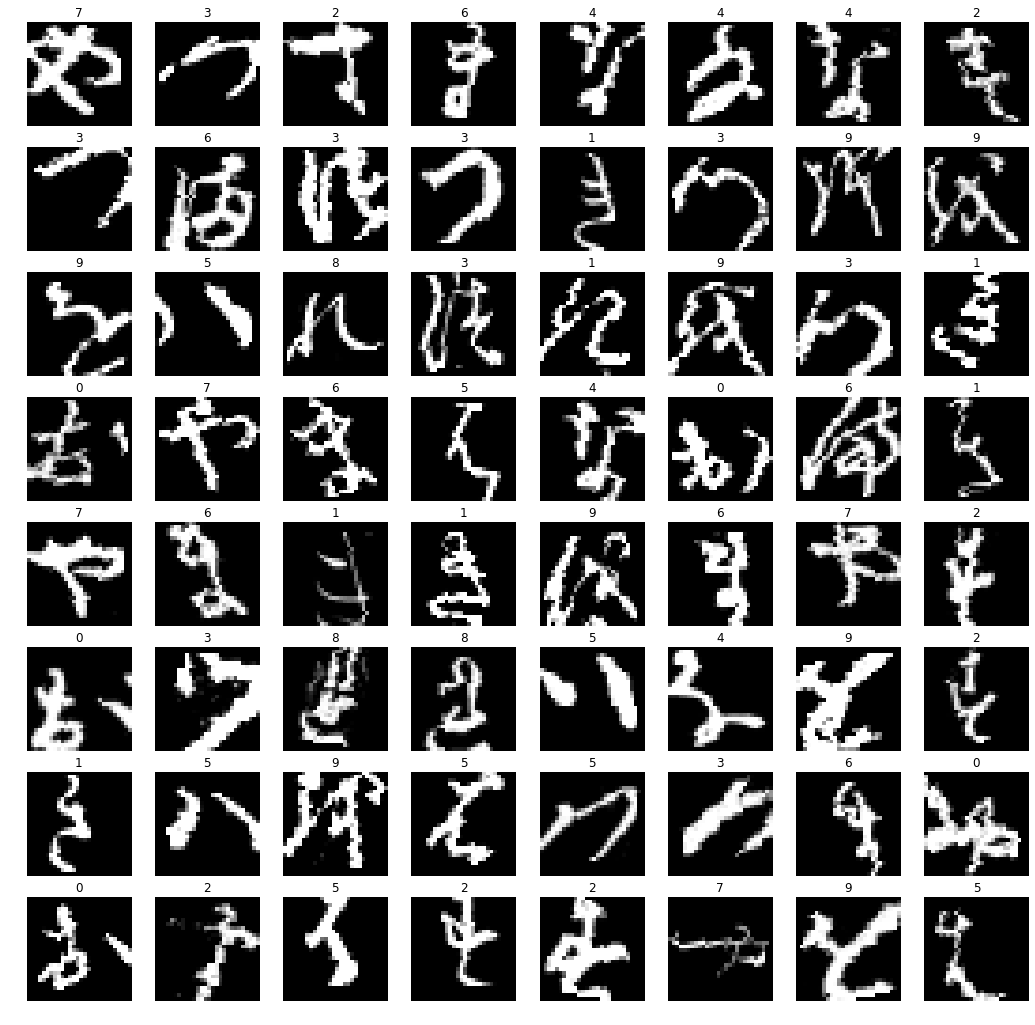

In [14]:
train_loader = data_loders[0, 0]
for X, y in train_loader:
    
    print("Loaded Feature Shape:", X.size())
    print("Loaded Target Shape:", y.size())
    print("batch mean:", X.mean())
    print("batch std:", X.std())
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

What about the standard deviation and mean. Here I manually do the transformation on each sample and look at the transformed data mean, std and shape.

In [15]:
norm = data_loders[0, 1].dataset.transform
manual = [norm(t) for t in train_feat]
manual = torch.stack(manual)
manual.mean(), manual.std(), manual.size()

(tensor(-0.0005), tensor(0.9996), torch.Size([60000, 1, 28, 28]))

## Define the Network

In [0]:
# AlexNet_half (Dropout)
class AlexNet_6_wide(nn.Module):
    """
    Neural Network inspired on Alexnet, with a reduced number of parameters (989410).
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(AlexNet_6_wide, self).__init__()

        # create the activation function
        act = nn.ReLU()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 32, padding=1, kernel_size=4, stride=1, bias=bias), act,
            nn.Conv2d(32, 86, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Conv2d(86, 86, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act,
            nn.Conv2d(86, 128, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Conv2d(128, 128, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.Conv2d(128, 86, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act)
        
        self.full_connected = nn.Sequential(
            nn.Linear(3096, 256, bias=bias), act,
            nn.Linear(256, 256, bias=bias), act,
            nn.Linear(256, 10, bias=bias)
        )

    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, T.size(1)*T.size(2)*T.size(3))
        
        
    def forward(self, x):
        "Pass through the neural network"
        x = self.convolutional(x)
        x = self.flatten(x)
        x = self.full_connected(x)
        return x

In [17]:
x = torch.randn((1, 1, 28, 28))
test_model = AlexNet_6_wide()

y = test_model(x)
print("Output (pre-softmax):\n", y.detach().numpy())

Output (pre-softmax):
 [[-0.05755547  0.0530102   0.01451544 -0.08151973 -0.02682329  0.00163084
   0.01908025 -0.00246319  0.02489133 -0.02588728]]


## Model Training

In [18]:
# setup
set_seed(Seed)
model = AlexNet_6_wide().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, weight_decay=Weight_decay, momentum=Momentum)
criterion = nn.CrossEntropyLoss()
train_loader, validate_loader = data_loders[0]

wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, 
                        criterion=criterion, device=device)
wrapper.num_model_params()

Number of model Parameters:  1637680


1637680

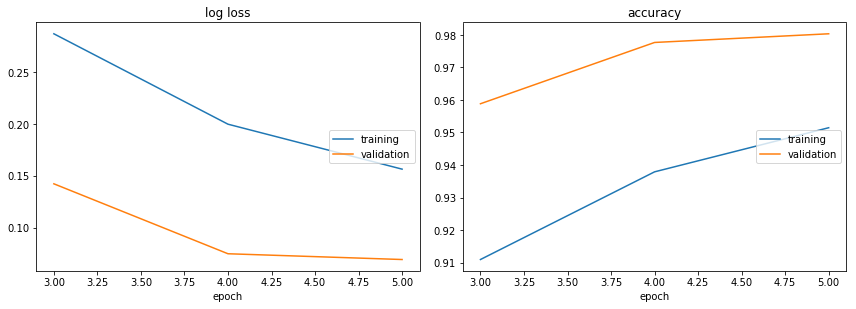

log loss:
training   (min:    0.156, max:    2.233, cur:    0.156)
validation (min:    0.069, max:    1.233, cur:    0.069)

accuracy:
training   (min:    0.150, max:    0.951, cur:    0.951)
validation (min:    0.544, max:    0.980, cur:    0.980)
Training Finished
saved to /content/gdrive/My Drive/models/AlexNet6_5.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_6_wide. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
wrapper.train_model(5)
wrapper.save_model("AlexNet6_5.pth")

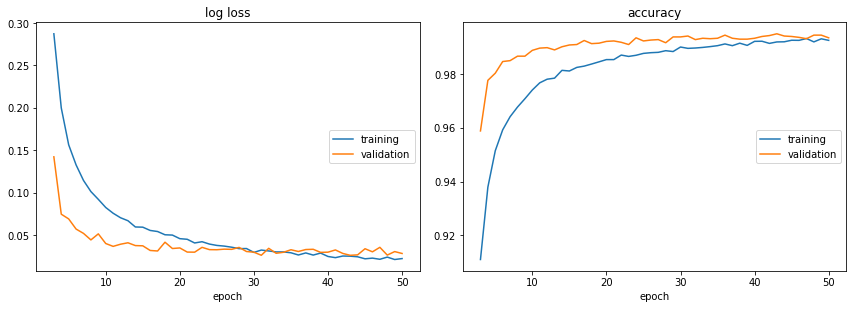

log loss:
training   (min:    0.021, max:    2.233, cur:    0.022)
validation (min:    0.026, max:    1.233, cur:    0.028)

accuracy:
training   (min:    0.150, max:    0.993, cur:    0.993)
validation (min:    0.544, max:    0.995, cur:    0.994)
Training Finished
saved to /content/gdrive/My Drive/models/AlexNet6_50.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_6_wide. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
wrapper.train_model(45)
wrapper.save_model("AlexNet6_50.pth")

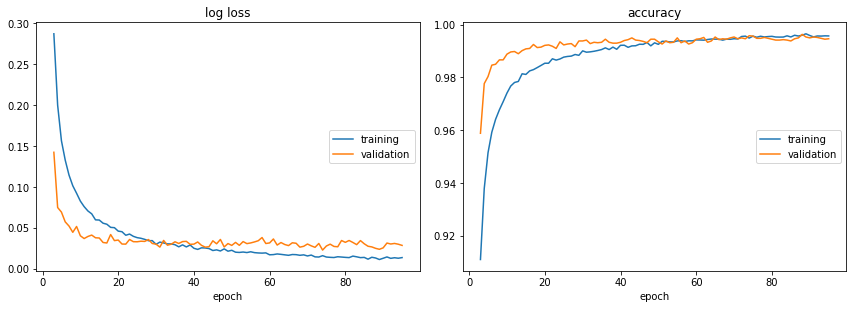

log loss:
training   (min:    0.011, max:    2.233, cur:    0.013)
validation (min:    0.023, max:    1.233, cur:    0.028)

accuracy:
training   (min:    0.150, max:    0.997, cur:    0.996)
validation (min:    0.544, max:    0.996, cur:    0.995)
Training Finished
saved to /content/gdrive/My Drive/models/AlexNet6_50.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_6_wide. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [38]:
wrapper.train_model(45)
wrapper.save_model("AlexNet6_50.pth")

## Save Model

Make a prediction

In [0]:
dictonary = torch.load("/content/gdrive/My Drive/models/AlexNet6_100.pth")
wrapper.model = dictonary['model']

In [0]:
pred = wrapper.evaluate(test_feat)
np.save("/content/gdrive/My Drive/models/Alex_net6_probs.np", pred)

In [31]:
pred = wrapper.evaluate(test_feat, False)
save_csv(pred, "Alex_net6_pred", path="/content/gdrive/My Drive/models/")

successfully saved in /content/gdrive/My Drive/models/Alex_net6_pred.csv
